# Categorical Variables

Categorical Variables in JAXSR
==============================

This example demonstrates how to use JAXSR with mixed continuous and
categorical input features.  A common scenario in science and engineering
is modelling a response that depends on continuous conditions (temperature,
pressure) *and* a discrete factor such as catalyst type or material grade.

JAXSR uses indicator (dummy) encoding to represent categorical variables
as binary basis functions, and can discover different intercepts and slopes
per category level automatically.

In [1]:
import numpy as np

from jaxsr import BasisLibrary, SymbolicRegressor
from jaxsr.sampling import grid_sample, latin_hypercube_sample

## 1. Generate synthetic data

**True model:**  $y = 2T + 5\,\mathbb{1}(\text{catalyst}=1) + 10\,\mathbb{1}(\text{catalyst}=2) + \varepsilon$

Three catalysts are encoded as integers: 0 (reference), 1, 2.

In [2]:
rng = np.random.RandomState(0)
n = 80

T = rng.uniform(300, 500, n)
catalyst = rng.choice([0, 1, 2], n)

y_true = 2.0 * T + 5.0 * (catalyst == 1) + 10.0 * (catalyst == 2)
y = y_true + rng.normal(0, 1.0, n)

X = np.column_stack([T, catalyst])

print("=== Data summary ===")
print(f"  {n} observations, 1 continuous + 1 categorical feature")
print(f"  Catalyst levels: {sorted(set(catalyst))}")

=== Data summary ===
  80 observations, 1 continuous + 1 categorical feature
  Catalyst levels: [np.int64(0), np.int64(1), np.int64(2)]


## 2. Build a basis library with categorical support

Key points:
skip categorical features, so you don't have to filter manually.

In [3]:
library = (
    BasisLibrary(
        n_features=2,
        feature_names=["T", "catalyst"],
        feature_types=["continuous", "categorical"],
        categories={1: [0, 1, 2]},
    )
    .add_constant()
    .add_linear()  # only adds T (skips categorical)
    .add_polynomials(max_degree=2)  # only T^2
    .add_categorical_indicators()  # I(catalyst=1), I(catalyst=2)
    .add_categorical_interactions()  # I(catalyst=1)*T, I(catalyst=2)*T
)

print(f"\n=== Basis library: {len(library)} functions ===")
for bf in library.basis_functions:
    print(f"  {bf.name}  (complexity={bf.complexity})")


=== Basis library: 7 functions ===
  1  (complexity=0)
  T  (complexity=1)
  T^2  (complexity=2)
  I(catalyst=1)  (complexity=1)
  I(catalyst=2)  (complexity=1)
  I(catalyst=1)*T  (complexity=2)
  I(catalyst=2)*T  (complexity=2)


## 3. Fit and inspect

In [4]:
model = SymbolicRegressor(basis_library=library, max_terms=5, strategy="greedy_forward")
model.fit(X, y)

print("\n=== Fitted model ===")
print(f"  Expression: {model.expression_}")
print(f"  R²: {model.score(X, y):.6f}")
print(f"  Selected features: {model.selected_features_}")


=== Fitted model ===
  Expression: y = 2*T + 10.5*I(catalyst=2) + 4.59*I(catalyst=1)
  R²: 0.999938
  Selected features: ['T', 'I(catalyst=2)', 'I(catalyst=1)']


Parameter Significance (95% CI):
             Term   Estimate   Std Err        t    p-value 95% CI
  ---------------------------------------------------------------------------
                T     2.0001    0.0004  4734.86   0.00e+00 [1.9992, 2.0009] ***
    I(catalyst=2)    10.5049    0.2527    41.56   0.00e+00 [10.0016, 11.0082] ***
    I(catalyst=1)     4.5904    0.2585    17.76   0.00e+00 [4.0756, 5.1052] ***
  --- *** p<0.001, ** p<0.01, * p<0.05


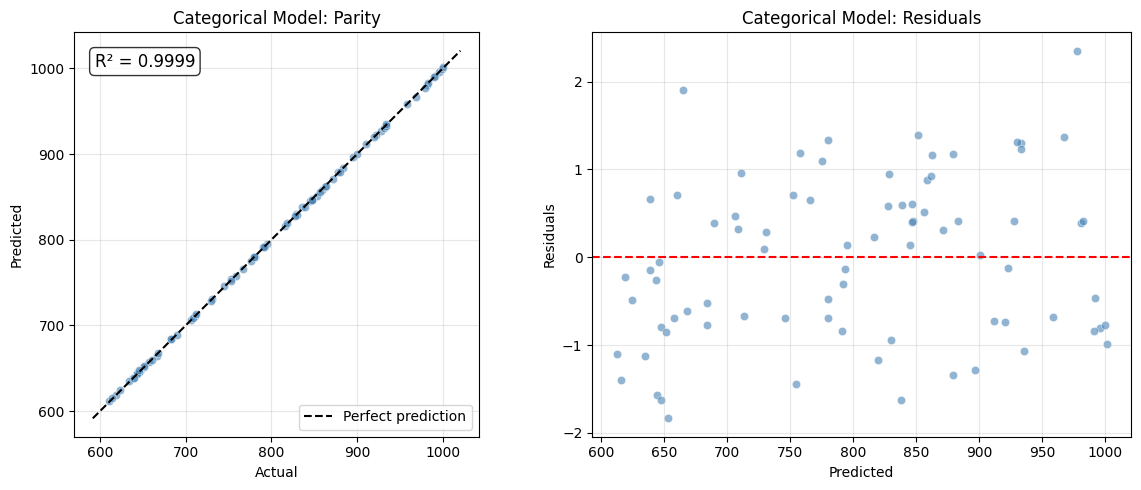


ANOVA Table (Categorical Model)
  Source                       DF        Sum Sq       Mean Sq           F     p-value
--------------------------------------------------------------------------------
  T                             1  1094206.4955  1094206.4955  1230820.72      0.0000
  I(catalyst=2)                 1     1255.6915     1255.6915     1412.47      0.0000
  I(catalyst=1)                 1      280.3598      280.3598      315.36      0.0000
  Model                         2  1095742.5466   547871.2733   616274.27      0.0000
  Residual                     77       68.4534        0.8890                        
  Total                        79  1095811.0000    13871.0253                        
--------------------------------------------------------------------------------

Variance Contributions:
  T                            99.9%  ***
  I(catalyst=2)                 0.1%  ***
  I(catalyst=1)                 0.0%  ***


In [5]:
# Parameter significance, diagnostics, and ANOVA
import matplotlib.pyplot as plt
from scipy import stats as sp_stats
from jaxsr import anova
from jaxsr.plotting import plot_parity

intervals = model.coefficient_intervals(alpha=0.05)
n_obs, k_terms = len(np.asarray(y)), len(model.selected_features_)
df_resid = n_obs - k_terms

print("Parameter Significance (95% CI):")
print(f"  {'Term':>15s} {'Estimate':>10s} {'Std Err':>9s} {'t':>8s} {'p-value':>10s} 95% CI")
print("  " + "-" * 75)
for name, (est, lo, hi, se) in intervals.items():
    t_val = est / se if abs(se) > 1e-15 else float("inf")
    p_val = float(2 * (1 - sp_stats.t.cdf(abs(t_val), df_resid))) if df_resid > 0 else 0.0
    sig = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else ""))
    print(f"  {name:>15s} {est:10.4f} {se:9.4f} {t_val:8.2f} {p_val:10.2e} [{lo:.4f}, {hi:.4f}] {sig}")
print("  --- *** p<0.001, ** p<0.01, * p<0.05")

y_pred = model.predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_parity(y, y_pred, ax=axes[0], title="Categorical Model: Parity")
residuals = np.array(y - y_pred)
axes[1].scatter(np.array(y_pred), residuals, alpha=0.6, c="steelblue", edgecolors="white", linewidth=0.5)
axes[1].axhline(y=0, color="r", linestyle="--")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Categorical Model: Residuals")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

anova_result = anova(model)
summary_sources = {"Model", "Residual", "Total"}
print("\nANOVA Table (Categorical Model)")
print("=" * 80)
print(f"  {'Source':25s}  {'DF':>4}  {'Sum Sq':>12}  {'Mean Sq':>12}  {'F':>10}  {'p-value':>10}")
print("-" * 80)
for row in anova_result.rows:
    f_str = f"{row.f_value:10.2f}" if row.f_value is not None else "          "
    p_str = f"{row.p_value:10.4f}" if row.p_value is not None else "          "
    print(f"  {row.source:25s}  {row.df:4d}  {row.sum_sq:12.4f}  {row.mean_sq:12.4f}  {f_str}  {p_str}")
print("-" * 80)
term_rows = [r for r in anova_result.rows if r.source not in summary_sources]
if term_rows:
    model_ss = sum(r.sum_sq for r in term_rows)
    print("\nVariance Contributions:")
    for row in term_rows:
        pct = 100 * row.sum_sq / model_ss if model_ss > 0 else 0
        sig = (
            "***" if row.p_value is not None and row.p_value < 0.001 else (
            "**" if row.p_value is not None and row.p_value < 0.01 else (
            "*" if row.p_value is not None and row.p_value < 0.05 else ""))
        )
        print(f"  {row.source:25s}  {pct:6.1f}%  {sig}")

## 4. Export to pure NumPy callable (no JAX needed at prediction time)

In [6]:
predict_fn = model.to_callable()
y_pred = predict_fn(np.array(X))
residual = np.abs(y - y_pred).mean()
print("\n=== NumPy callable ===")
print(f"  Mean absolute residual: {residual:.4f}")


=== NumPy callable ===
  Mean absolute residual: 0.7910


## 5. Sampling with discrete dimensions

When designing experiments, categorical dimensions should only take
their valid levels.  Pass discrete_dims to the sampling functions.

In [7]:
bounds = [(300, 500), (0, 2)]
discrete = {1: [0, 1, 2]}

X_lhs = latin_hypercube_sample(20, bounds, random_state=42, discrete_dims=discrete)
print("\n=== LHS with discrete dims ===")
print(f"  Shape: {X_lhs.shape}")
print(f"  Catalyst values: {sorted(set(np.array(X_lhs[:, 1]).tolist()))}")

X_grid = grid_sample(5, bounds, discrete_dims=discrete)
print("\n=== Grid with discrete dims ===")
print(f"  Shape: {X_grid.shape}  (5 continuous * 3 discrete = 15)")


=== LHS with discrete dims ===
  Shape: (20, 2)
  Catalyst values: [0.0, 1.0, 2.0]

=== Grid with discrete dims ===
  Shape: (15, 2)  (5 continuous * 3 discrete = 15)


## 6. build_default() handles categorical features automatically

If any features are categorical, build_default() adds indicators and
categorical interactions alongside the standard continuous basis set.

In [8]:
auto_library = BasisLibrary(
    n_features=2,
    feature_names=["T", "catalyst"],
    feature_types=["continuous", "categorical"],
    categories={1: [0, 1, 2]},
).build_default()

auto_model = SymbolicRegressor(basis_library=auto_library, max_terms=5)
auto_model.fit(X, y)
print("\n=== build_default() with categorical ===")
print(f"  Library size: {len(auto_library)}")
print(f"  Expression: {auto_model.expression_}")
print(f"  R²: {auto_model.score(X, y):.6f}")

/var/folders/gq/k1kgbl7n539_4dl1md8x3jt80000gn/T/ipykernel_62493/1717600031.py:9: UserWarning: Removing 1 basis functions with non-finite values
  auto_model.fit(X, y)



=== build_default() with categorical ===
  Library size: 12
  Expression: y = 2.002*T + 10.48*I(catalyst=2) + 4.692*I(catalyst=1) - 311.8*1/T
  R²: 0.999941
